In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset, BatchSampler, WeightedRandomSampler
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision import models
from torchvision.models import VGG16_Weights
import torch.optim as optim
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# DATA PREPARATION

In [3]:
class KeratoconusMultiInputDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.classes = {
            "Keratoconus": "KCN",
            "Normal": "NOR",
            "Suspect": "SUSP"
        }  
        self.features = ["CT_A", "EC_A", "EC_P", "Elv_A", "Elv_P", "Sag_A", "Sag_P"]
        self.transform = transform
        self.data = []

        print("Processing Dataset")
        
        for folder_name, class_code in self.classes.items():
            class_path = os.path.join(root_dir, folder_name)
            if not os.path.isdir(class_path):
                print(f"[!] Class Folder Unfound : {class_path}")
                continue

            for case_folder in os.listdir(class_path):
                case_path = os.path.join(class_path, case_folder)
                if not os.path.isdir(case_path):
                    continue  

                case_dict = {}

                for filename in os.listdir(case_path):
                    file_path = os.path.join(case_path, filename)
                    if not os.path.isfile(file_path):
                        continue  

                    parts = filename.split('_')
                    if len(parts) < 3:
                        continue  

                    feature_code = parts[2] + "_" + parts[3].split('.')[0]  

                    if feature_code not in self.features:
                        continue  

                    case_dict[feature_code] = file_path

                if len(case_dict) == 7:
                    class_index = list(self.classes.keys()).index(folder_name)  # Pastikan indeks sesuai
                    self.data.append((list(case_dict.values()), class_index))
        
        print(f"✅ Total case dalam dataset: {len(self.data)}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_paths, label = self.data[idx]
        images = [Image.open(img).convert("RGB") for img in img_paths]

        if self.transform:
            images = [self.transform(img) for img in images]

        images = torch.stack(images)

        # 🔍 Debugging untuk memastikan file dan label cocok
        print(f"📝 Debug: Mengambil data index {idx}")
        print(f"    🔹 Nama file pertama: {os.path.basename(img_paths[0])}")
        print(f"    🔹 Label dataset: {label} ({['Keratoconus', 'Normal', 'Suspect'][label]})")

        return images, label

In [4]:
# **2️⃣ Fungsi untuk Memuat Dataset**
def load_dataset(root_dir):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
    ])
    
    dataset = KeratoconusMultiInputDataset(root_dir, transform=transform)
    return dataset

In [5]:
def split_train_val(dataset, val_ratio=0.2):
    """Memisahkan dataset menjadi train dan validation set secara manual tanpa shuffle."""
    
    # 🔍 Buat dictionary untuk menyimpan indeks dataset berdasarkan kelas
    class_indices = {0: [], 1: [], 2: []}  # 0 = Keratoconus, 1 = Normal, 2 = Suspect

    for idx in range(len(dataset)):
        label = dataset[idx][1]  # Ambil label dataset
        class_indices[label].append(idx)

    # Pastikan urutan tetap berdasarkan case (case1, case2, ...)
    for label in class_indices:
        class_indices[label].sort()

    train_idx = []
    val_idx = []

    # **Pisahkan dataset setiap kelas dengan proporsi yang sama**
    for label, indices in class_indices.items():
        split_point = int(len(indices) * (1 - val_ratio))  # Hitung jumlah train & validation
        train_idx.extend(indices[:split_point])
        val_idx.extend(indices[split_point:])

    # **Tampilkan hasil split**
    print(f"✅ Train set: {len(train_idx)} (K: {len([i for i in train_idx if dataset[i][1] == 0])}, "
          f"N: {len([i for i in train_idx if dataset[i][1] == 1])}, "
          f"S: {len([i for i in train_idx if dataset[i][1] == 2])})")
    print(f"✅ Validation set: {len(val_idx)} (K: {len([i for i in val_idx if dataset[i][1] == 0])}, "
          f"N: {len([i for i in val_idx if dataset[i][1] == 1])}, "
          f"S: {len([i for i in val_idx if dataset[i][1] == 2])})")

    train_dataset = Subset(dataset, train_idx)
    val_dataset = Subset(dataset, val_idx)

    return train_dataset, val_dataset

In [6]:
# **4️⃣ Oversampling: Buat Dataset Seimbang**
def balance_dataset(dataset):
    labels = [dataset[i][1] for i in range(len(dataset))]
    class_counts = np.bincount(labels)
    max_count = max(class_counts)

    new_indices = []
    for label in range(len(class_counts)):
        class_indices = [i for i, lbl in enumerate(labels) if lbl == label]
        num_additional = max_count - len(class_indices)
        sampled_indices = np.random.choice(class_indices, num_additional, replace=True)
        new_indices.extend(class_indices + sampled_indices.tolist())

    np.random.shuffle(new_indices)
    balanced_dataset = Subset(dataset, new_indices)
    return balanced_dataset

In [7]:
# **5️⃣ Custom Batch Sampler untuk Kelas yang Sama dalam Satu Batch**
class ClassWiseBatchSampler(BatchSampler):
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.class_indices = {}

        for idx in range(len(dataset)):
            label = dataset[idx][1]
            if label not in self.class_indices:
                self.class_indices[label] = []
            self.class_indices[label].append(idx)

        for label in self.class_indices:
            np.random.shuffle(self.class_indices[label])

        self.class_batches = []
        
        for label, indices in self.class_indices.items():
            for i in range(0, len(indices), batch_size):
                batch = indices[i:i + batch_size]
                if len(batch) == batch_size:
                    self.class_batches.append(batch)
        
        np.random.shuffle(self.class_batches)  
    
    def __iter__(self):
        return iter(self.class_batches)
    
    def __len__(self):
        return len(self.class_batches)


In [8]:
def get_dataloaders(train_dataset, val_dataset, batch_size=8, use_oversampling=True):
    """Membuat DataLoader dengan ClassWiseBatchSampler agar setiap batch hanya memiliki satu kelas."""
    
    train_sampler = ClassWiseBatchSampler(train_dataset, batch_size=batch_size)
    val_sampler = ClassWiseBatchSampler(val_dataset, batch_size=batch_size)

    train_loader = DataLoader(train_dataset, batch_sampler=train_sampler)
    val_loader = DataLoader(val_dataset, batch_sampler=val_sampler)

    return train_loader, val_loader

In [9]:
def check_batch_size(dataloader):
    """Menampilkan jumlah data dalam satu batch pertama dan memeriksa kesesuaian label."""
    images, labels = next(iter(dataloader))  # Ambil batch pertama #pick 1st batch
    print(f"📊 Total data dalam batch pertama: {images.shape[0]}")
    print(f"📌 Semua label dalam batch: {labels.numpy()}")
    
    # 🚨 Pastikan semua label dalam batch adalah sama
    # ensure same label for each batch
    unique_labels = set(labels.numpy())
    if len(unique_labels) > 1:
        print("❌ ERROR: Batch memiliki lebih dari satu kelas!")
    else:
        print("✅ Batch hanya memiliki satu kelas.")

    return labels.numpy()

In [10]:
def show_batch(dataset, dataloader, num_images=7):
    """Menampilkan gambar dari satu batch dengan nama file yang sesuai."""

    images, labels = next(iter(dataloader))  # Ambil satu batch dari DataLoader # pick 1 batch from DataLoader
    batch_size = images.shape[0]  

    # 🔍 Debugging Dimensi
    print(f"🔍 Shape images sebelum pemilihan fitur: {images.shape}")  

    # **Ambil indeks dataset asli dari batch yang sedang digunakan**
    if isinstance(dataloader.dataset, Subset):
        batch_indices = [dataloader.dataset.indices[i] for i in range(batch_size)]
    else:
        batch_indices = list(range(batch_size))

    # **Ambil nama file yang benar sesuai dengan indeks yang telah diperbaiki**
    filenames = [dataset.data[idx][0] for idx in batch_indices]  # Ambil daftar file berdasarkan indeks

    # **Ambil hanya satu gambar per case (misalnya gambar pertama)**
    filenames = [file_list[0] for file_list in filenames]  # ✅ Ambil path gambar pertama dari setiap case

    # 🔍 Debugging: Pastikan label dan indeks sesuai
    print(f"📂 Indeks dataset dalam batch: {batch_indices}")
    print(f"📌 Label dalam batch: {labels.numpy()}")
    print(f"📝 Nama file yang digunakan dalam batch: {filenames}")  

    # **Ambil hanya satu gambar per case**
    images = images[:, 0]  # Ambil hanya gambar pertama dari setiap case
    print(f"🔍 Shape images setelah pemilihan fitur: {images.shape}")  

    # **Denormalisasi gambar agar tampilannya sesuai dengan aslinya**
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)  
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)  
    images = images * std + mean  

    fig, axes = plt.subplots(1, num_images, figsize=(18, 5))
    class_names = ["Keratoconus", "Normal", "Suspect"]

    for i in range(min(num_images, batch_size)):  # Pastikan tidak lebih dari batch size
        img = images[i].permute(1, 2, 0).numpy()  # ✅ Sekarang tensor sudah memiliki (3, 224, 224)
        filename = os.path.basename(filenames[i])  # ✅ Sekarang ini hanya satu path file, bukan list

        print(f"🖼️ Menampilkan: {filename} | Class: {class_names[labels[i].item()]}")  # Debugging

        axes[i].imshow(np.clip(img, 0, 1))  # Pastikan nilai dalam rentang 0-1
        axes[i].set_title(f"{filename}\nClass: {class_names[labels[i].item()]}", fontsize=8)
        axes[i].axis("off")

    plt.suptitle(f"🔍 Contoh Gambar dari Batch (Total: {num_images} Gambar)", fontsize=14)
    plt.show()


# MODEL SETUP

In [11]:
def create_vgg16_model():
    """Membuat model VGG16 dengan classifier baru untuk klasifikasi 3 kelas."""
    
    print("🔧 Memuat VGG16 Pretrained...")
    model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)  # Load VGG16 dengan pretrained weights dari ImageNet

    # modify classifier as 3 classes
    model.classifier = nn.Sequential(
        nn.Linear(25088, 4096),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(4096, 1024),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(1024, 3)  # output layer for 3 classes
    )

    # 🔐 Freeze seluruh feature extractor (Conv layers)
    for param in model.features.parameters():
        param.requires_grad = False

    # ✅ Unfreeze hanya layer classifier (agar bisa ditraining)
    for param in model.classifier.parameters():
        param.requires_grad = True

    print("✅ Model VGG16 siap digunakan!")
    return model

# 📌 Coba load model
model = create_vgg16_model()
print(model)

🔧 Memuat VGG16 Pretrained...


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 214MB/s] 


✅ Model VGG16 siap digunakan!
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, s

In [12]:


def setup_training(model, learning_rate=1e-3, feature_learning_rate=1e-6):
    """Mempersiapkan optimizer dan loss function untuk training."""
    
    print("🔧 Menyiapkan optimizer dan loss function...")
    
    # **Gunakan Adam Optimizer**
    optimizer = optim.Adam([
        {'params': model.features.parameters(), 'lr': feature_learning_rate},  # Feature extractor (low learning rate)
        {'params': model.classifier.parameters(), 'lr': learning_rate}  # Classifier (higher learning rate)
    ])

    # **Gunakan CrossEntropyLoss karena ini klasifikasi multi-kelas**
    criterion = nn.CrossEntropyLoss()

    print("✅ Optimizer dan loss function siap digunakan!")
    return optimizer, criterion

# 📌 Coba setup optimizer & loss function
optimizer, criterion = setup_training(model)
print(optimizer)
print(criterion)

🔧 Menyiapkan optimizer dan loss function...
✅ Optimizer dan loss function siap digunakan!
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1e-06
    maximize: False
    weight_decay: 0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
CrossEntropyLoss()


In [13]:


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, device="cuda"):
    """Melatih model dengan menyimpan model terbaik berdasarkan kombinasi validation loss & accuracy."""
    
    model.to(device)  # Pindahkan model ke GPU jika tersedia
    best_loss = float("inf")  # Simpan best validation loss untuk early stopping
    best_acc = 0.0  # Simpan best validation accuracy
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    print("🚀 Memulai Training...")
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # **Training Phase**
        model.train()
        train_loss, train_correct = 0.0, 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()  # Reset gradient

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Hitung loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weight
            
            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = train_loss / total_train
        train_acc = train_correct / total_train

        # **Validation Phase**
        model.eval()
        val_loss, val_correct = 0.0, 0
        total_val = 0

        with torch.no_grad():  # Disable gradient untuk validasi
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                total_val += labels.size(0)

        avg_val_loss = val_loss / total_val
        val_acc = val_correct / total_val

        # **Simpan history loss dan akurasi**
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        # **Gunakan kombinasi Validation Loss & Accuracy untuk menyimpan model terbaik**
        combined_score = avg_val_loss - (0.5 * val_acc)
        if combined_score < best_loss or val_acc > best_acc:
            best_loss = combined_score
            best_acc = val_acc
            torch.save(model.state_dict(), "best_vgg16_model.pth")
            print(f"🔽 Model disimpan! (Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}, Score: {combined_score:.4f})")

        # **Tampilkan hasil epoch**
        elapsed_time = time.time() - start_time
        print(f"📅 Epoch [{epoch+1}/{num_epochs}] - "
              f"🟢 Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"🔵 Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f} | "
              f"⏱️ Time: {elapsed_time:.2f}s")

    print("🎉 Training selesai!")
    return history


🔍 Memulai pemrosesan dataset...
✅ Total case dalam dataset: 423
📝 Debug: Mengambil data index 0
    🔹 Nama file pertama: KCN_12_CT_A.jpg
    🔹 Label dataset: 0 (Keratoconus)
📝 Debug: Mengambil data index 1
    🔹 Nama file pertama: KCN_36_Sag_P.jpg
    🔹 Label dataset: 0 (Keratoconus)
📝 Debug: Mengambil data index 2
    🔹 Nama file pertama: KCN_69_Elv_P.jpg
    🔹 Label dataset: 0 (Keratoconus)
📝 Debug: Mengambil data index 3
    🔹 Nama file pertama: KCN_22_CT_A.jpg
    🔹 Label dataset: 0 (Keratoconus)
📝 Debug: Mengambil data index 4
    🔹 Nama file pertama: KCN_135_Sag_A.jpg
    🔹 Label dataset: 0 (Keratoconus)
📝 Debug: Mengambil data index 5
    🔹 Nama file pertama: KCN_20_Elv_A.jpg
    🔹 Label dataset: 0 (Keratoconus)
📝 Debug: Mengambil data index 6
    🔹 Nama file pertama: KCN_77_CT_A.jpg
    🔹 Label dataset: 0 (Keratoconus)
📝 Debug: Mengambil data index 7
    🔹 Nama file pertama: KCN_44_Elv_A.jpg
    🔹 Label dataset: 0 (Keratoconus)
📝 Debug: Mengambil data index 8
    🔹 Nama file pe

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


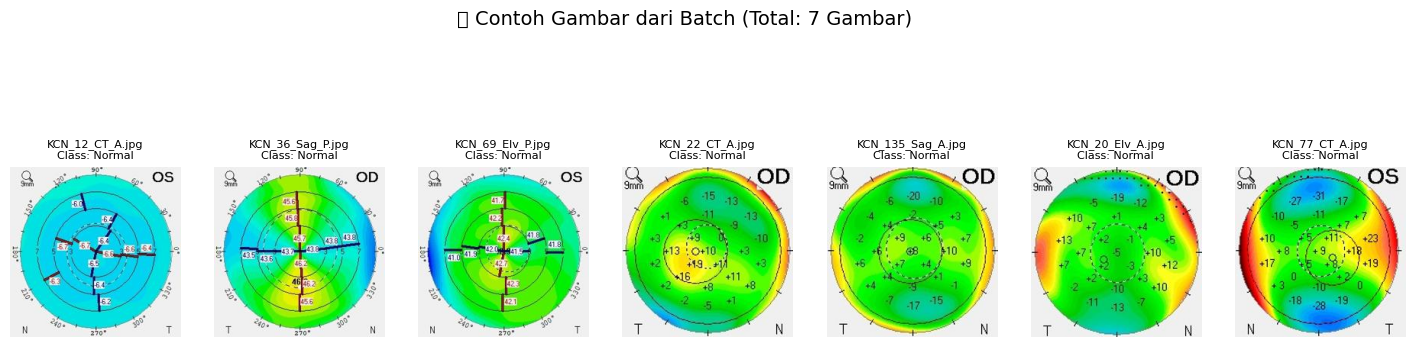

🚀 Memulai Training...
📝 Debug: Mengambil data index 250
    🔹 Nama file pertama: NOR_66_Sag_P.jpg
    🔹 Label dataset: 1 (Normal)
📝 Debug: Mengambil data index 193
    🔹 Nama file pertama: NOR_45_Sag_A.jpg
    🔹 Label dataset: 1 (Normal)
📝 Debug: Mengambil data index 197
    🔹 Nama file pertama: NOR_70_Sag_A.jpg
    🔹 Label dataset: 1 (Normal)
📝 Debug: Mengambil data index 187
    🔹 Nama file pertama: NOR_138_EC_P.jpg
    🔹 Label dataset: 1 (Normal)
📝 Debug: Mengambil data index 195
    🔹 Nama file pertama: NOR_63_EC_P.jpg
    🔹 Label dataset: 1 (Normal)
📝 Debug: Mengambil data index 268
    🔹 Nama file pertama: NOR_106_Elv_P.jpg
    🔹 Label dataset: 1 (Normal)
📝 Debug: Mengambil data index 258
    🔹 Nama file pertama: NOR_150_EC_A.jpg
    🔹 Label dataset: 1 (Normal)
📝 Debug: Mengambil data index 184
    🔹 Nama file pertama: NOR_76_EC_A.jpg
    🔹 Label dataset: 1 (Normal)


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [8, 7, 3, 224, 224]

In [14]:
def main():
    root_dir = "/kaggle/input/cornealtopography/Train_Validation sets/Train_Validation sets"

    dataset = load_dataset(root_dir)
    train_dataset, val_dataset = split_train_val(dataset)

    train_loader, val_loader = get_dataloaders(train_dataset, val_dataset, use_oversampling=True)

    print("🔍 Memeriksa DataLoader...")
    check_batch_size(train_loader)

    print("🛠 Debugging: Mengecek dataset asli untuk melihat apakah pemetaan file sudah benar.")
    for i in range(5):  # Cek 5 sampel pertama dalam dataset
        images, label = dataset[i]  # Ambil data dari dataset asli
        filename = dataset.data[i][0][0]  # Ambil path file pertama dari case tersebut
        print(f"✅ Sample {i}: Label {label} ({['Keratoconus', 'Normal', 'Suspect'][label]}) | Nama file: {filename}")

    print("🖼️ Menampilkan contoh gambar dari batch pertama dengan nama file:")
    show_batch(dataset, train_loader)

    history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, device="cuda" if torch.cuda.is_available() else "cpu")

if __name__ == "__main__":
    main()